# Tweet, Trade, Profit: Exploring the Relationship between Elon Musk's Tweets and Dogecoin Volatility with NLP and Econometric Approach

<p align="center"><img src="doge.jpg" alt="Texto alternativo" style="width: 70%;">


In recent years, social media platforms have become a powerful tool for investors seeking to gain an edge in the financial markets. Among the most influential social media figures in the investment community is Elon Musk, the billionaire entrepreneur and CEO of companies such as SpaceX and Tesla. In particular, Musk's tweets about cryptocurrencies such as Dogecoin have been known to cause significant price movements in the market.

The hypothesis of this study is that Elon Musk's tweets about Dogecoin can significantly impact the cryptocurrency's volatility and price movements. By analyzing Musk's tweet history and correlating it with market data on Dogecoin, we aim to identify trading opportunities that can benefit from the resulting increase in volatility.

The analysis is divided in diferent sections:

1. Downloading DOGE prices
2. Volatility has entered the chat
3. Elon Musk's tweets: the ultimate source of memes and controversy
4. Natural Language Processing (NLP) Techniques
    + Tokenization
    + Stop words
    + Lemmatization
    + Keywords & regex filter
5. Statistical models
    + Price analysis
    + Volatility analysis
6. Possible trading strategies and final thoughts

First we need to import the libraries that we going to use for the analysis

In [67]:
# pandas and numpy for data manipulation and analysis
import pandas as pd
import numpy as np

# re and json for regular expression operations and JSON parsing respectively
import re
import json

# ccxt for cryptocurrency trading APIs
import ccxt

# nltk for natural language processing tasks such as tokenization, stopword removal, and lemmatization
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# statsmodels for statistical modeling and analysis
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm

# plotly and matplotlib for data visualization
import plotly.graph_objs as go
import plotly.express as px
import plotly.io as pio
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

# wordcloud for generating word clouds from text data
from wordcloud import WordCloud

### 1. Downloading DOGE prices
We use ccxt to create an instance of the Binance exchange API and fetch OHLCV data for the DOGE/USDT trading pair at a 1-hour timeframe since January 1st, 2021. We then retrieve the data in batches and append it to a Pandas DataFrame for further analysis. 

`ccxt` is a popular open-source library that provides a uniform interface for accessing various cryptocurrency exchange APIs. A while loop is used to download the historical OHLCV data in batches of 500 observations each. The reason for this is that many cryptocurrency exchange APIs have rate limits on data requests to prevent excessive traffic and potential overload on their servers. By limiting the number of observations in each request, we can reduce the chances of hitting these rate limits and ensure that our data is downloaded efficiently.

In [2]:
#Create an instance of the Binance exchange API
exchange = ccxt.binance()

#Define the trading pair symbol to fetch data for
symbol = 'DOGE/USDT'

#Define the timeframe to fetch data for
timeframe = '1h'

#Define the starting date to fetch data from
from_date = '2021-01-01T00:00:00Z'

#Set the number of candles to retrieve in each request
limit = 500

#Initialize an empty list to store the fetched OHLCV data
ohlcv = []

#Loop through the data requests until all data is fetched
while True:
    data = exchange.fetch_ohlcv(symbol, timeframe, since=exchange.parse8601(from_date), limit=limit)
    ## Append the fetched data to the ohlcv list
    ohlcv += data
    if len(data) < limit:
        break
    from_date = exchange.iso8601(data[-1][0]+1)  # Set the new from_date to avoid duplicates

#Create a Pandas DataFrame from the fetched OHLCV data
df_doge = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])

#Convert the timestamp column to a datetime format
df_doge['timestamp'] = pd.to_datetime(df_doge['timestamp'], unit='ms')

#Display the first five rows of the DataFrame
df_doge.head()

timestamp      open      high       low     close       volume
0 2021-01-01 00:00:00  0.004672  0.004701  0.004601  0.004679   27682073.0
1 2021-01-01 01:00:00  0.004678  0.004764  0.004676  0.004737   45350221.0
2 2021-01-01 02:00:00  0.004731  0.004759  0.004719  0.004755   17278135.0
3 2021-01-01 03:00:00  0.004752  0.004999  0.004751  0.004978  165646699.0
4 2021-01-01 04:00:00  0.004978  0.005000  0.004800  0.004894  147434756.0

We can visualize the data in a plotly chart:

In [3]:
pio.templates.default = "plotly_dark" # set dark background

fig = go.Figure()
fig.add_trace(go.Scatter(x=df_doge['timestamp'], y=df_doge['close'], name='DOGE-USD',
                         line=dict(color='#e1b303', width=2)))

fig.update_layout(title=('Hitorical closing price of DOGE/USDT in Binance'),
                  xaxis_title='Date',
                  yaxis_title='Cumulative performance',
                  font=dict(color='white'),
                  paper_bgcolor='black',
                  plot_bgcolor='black',
                  legend=dict(x=0, y=1.2, bgcolor='rgba(0,0,0,0)'),
                  yaxis=dict(gridcolor='rgba(255,255,255,0.2)'),
                  xaxis=dict(gridcolor='rgba(255,255,255,0.2)'))
fig.update_xaxes(showgrid=True, ticklabelmode="period")
fig.update_yaxes(showgrid=True)
fig.show()

### 2. Volatility has entered the chat

Volatility is a commonly used measure of risk in financial markets. It refers to the degree of variation in the price or value of an asset over a certain period of time. Higher volatility is generally associated with higher risk, as it implies a greater degree of uncertainty and unpredictability in the asset's value.

In the context of cryptocurrency trading, volatility is a particularly important metric, as many cryptocurrencies are known for their high levels of price volatility (DOGE and SHIBA are extreme examples). In order to calculate volatility, we can use the standard deviation of the logarithmic returns of the asset's price over a certain time period. The formula for calculating volatility in an OHLCV dataframe is:

$\sigma = \sqrt{\frac{1}{n-1}\sum_{i=1}^{n}(r_i - \bar{r})^2} \times \sqrt{N}$
​

where $\sigma$ is the volatility, $r_i$ is the logarithmic return at time $i$, $\bar{r}$ is the average logarithmic return, and $n$ is the number of observations.

where $P_i$ is the closing price of the asset at time $i$, $n$ is the total number of observations, $\overline{ln}$ is the average of the logarithmic returns, and $\sigma$ is the volatility.

Measuring the impact of news or important opinions (such as Elon Musk's tweets) in volatility rather than in price is a good idea because it allows us to more accurately capture the underlying sentiment and market reaction to the news. In many cases, the impact of news on an asset's price may be short-lived or may not fully reflect the true sentiment of the market. By measuring the impact of volatility, we can more effectively capture the level of uncertainty and risk associated with the news, which can be valuable information for traders and investors.

Furthermore, volatility-based trading strategies are often more effective than price-based strategies in high-volatility markets, as they can help to mitigate risk and take advantage of sudden price movements. By analyzing the relationship between news and volatility in cryptocurrency markets, we can develop more effective trading strategies that are better suited to the unique characteristics of these markets.

In [4]:
# Calculate the log returns of the closing prices
log_returns = np.log(df_doge['close']) - np.log(df_doge['close'].shift(1))

# Calculate the volatility using a rolling window of 24 hours
df_doge['volatility'] = log_returns.rolling(window=24).std() * 100

We can visualize the data in a plotly chart:


In [5]:
# Create a bar chart with the close price and volatility
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_doge['timestamp'], y=df_doge['close'], name='Close', line_color='#e1b303'))
fig.add_trace(go.Bar(x=df_doge['timestamp'], y=df_doge['volatility'], name='Volatility', 
                     marker_color='#eeeeee', yaxis='y2', width=0.8, opacity=0.4,
                     marker_line_width=0))

# Add title and axis labels
fig.update_layout(title='DOGE/USDT Close Price and Volatility',
                  xaxis_title='Date',
                  yaxis_title='Price (USDT)',
                  yaxis2=dict(title='Volatility', overlaying='y', side='right'),
                  plot_bgcolor='#111111',
                  paper_bgcolor='#111111',
                  yaxis=dict(gridcolor='white'))

# Show the chart
fig.show()


### 3. Elon Musk's tweets: the ultimate source of memes and controversy


Elon Musk, the co-founder and CEO of SpaceX and Tesla, is one of the most popular figures in the tech industry today. Musk has a massive following on Twitter, where he frequently shares his thoughts and updates on his various companies. As a result, analyzing his tweets has become a popular way to gain insight into his business strategies and thought process.

In this article, we will be analyzing a dataset of tweets posted by Elon Musk. The dataset was downloaded from [Data World](https://data.world/barbaramaseda/elon-musk-tweets) and consists of tweets that were collected automatically using an IFTTT applet. The dataset includes a variety of information such as the tweet text, username, link to the tweet, and the date it was posted.

In [6]:
# Open the JSONL file and read each line as a separate JSON object
with open('C:/Trading algoritmico/DOGE Musk/user-tweets.jsonl') as f:
    data = [json.loads(line) for line in f]

# Convert the list of JSON objects to a Pandas DataFrame
df_musk = pd.DataFrame.from_records(data)

# Drop the columns UserName and TweetEmbedCode using the drop method from pandas:
df_musk = df_musk.drop(['UserName', 'TweetEmbedCode'], axis=1)

# Convert the 'CreatedAt' column to datetime format
df_musk['CreatedAt'] = pd.to_datetime(df_musk['CreatedAt'])

# Subtract one hour from the CreatedAt column to adjust to UTC-Time
df_musk['CreatedAt'] = df_musk['CreatedAt'] - pd.Timedelta(hours=1)

# Filter the data starting 1-1-2021
df_musk = df_musk[df_musk['CreatedAt'] >= '2021-01-01']

# Print the first 10 rows of the DataFrame
df_musk

Text  \
9834   @comma_ai Tesla Full Self-Driving will work at...   
9835   @newscientist Um, we have giant fusion reactor...   
9836   RT @Tesla: In 2020, we produced and delivered ...   
9837   So proud of the Tesla team for achieving this ...   
9838   @flcnhvy Tesla is responsible for 2/3 of all t...   
...                                                  ...   
20977  @teslaownersSV There is massive uncertainty wi...   
20978  @dvorahfr You should sign up for subscriptions...   
20979  @SmokeAwayyy With booster ultimately flying up...   
20980                      @MrAndyNgo @FloridaState Wow!   
20981                 @EndWokeness Odd for period pieces   

                                             LinkToTweet           CreatedAt  
9834   http://twitter.com/elonmusk/status/13452083919... 2021-01-02 02:20:00  
9835   http://twitter.com/elonmusk/status/13453449587... 2021-01-02 11:23:00  
9836   http://twitter.com/elonmusk/status/13453809260... 2021-01-02 13:46:00  
9837   http://twitter.com/elonmusk/status/13453822949... 2021-01-02 13:51:00  
9838   http://twitter.com/elonmusk/status/13453841399... 2021-01-02 13:59:00  
...                                                  ...                 ...  
20977  https://twitter.com/elonmusk/status/1647059319... 2023-04-15 02:08:00  
20978  https://twitter.com/elonmusk/status/1647093557... 2023-04-15 04:24:00  
20979  https://twitter.com/elonmusk/status/1647096182... 2023-04-15 04:35:00  
20980  https://twitter.com/elonmusk/status/1647097813... 2023-04-15 04:41:00  
20981  https://twitter.com/elonmusk/status/1647098865... 2023-04-15 04:45:00  

[11148 rows x 3 columns]

The result is a dataframe with 20981 Elon Musk tweets. We can visualize the data in a plotly chart:


In [7]:
# Group the tweets by month and count the number of tweets per month
tweet_counts = df_musk.groupby(df_musk['CreatedAt'].dt.strftime('%B %Y'))['Text'].count()

# Convert the month name to a numerical value and sort the index
months = pd.to_datetime(tweet_counts.index, format='%B %Y').strftime('%Y-%m')
tweet_counts = tweet_counts.sort_index(key=lambda x: months)

# Create the Plotly bar plot
fig = px.bar(x=tweet_counts.index, y=tweet_counts.values,
             labels={'x': 'Month', 'y': 'Number of tweets'},
             title='Quantity of tweets per month')
fig.update_layout(plot_bgcolor='black', paper_bgcolor='black',
                  font_color='white', title_font_color='white',
                  xaxis_tickangle=-45, xaxis_tickfont=dict(size=14),
                  yaxis_tickfont=dict(size=14), showlegend=False)
fig.update_traces(marker_color='#e1b303')
fig.show()


### 4. Natural Language Processing (NLP) Techniques

Natural Language Processing (NLP) techniques are a set of tools and algorithms used to analyze and understand human language. With the explosion of data and information available on the internet, NLP has become increasingly important in fields such as machine learning, artificial intelligence, and data science.

When analyzing Elon Musk's tweets related to Dogecoin, applying these NLP techniques can help filter out irrelevant information and focus on the most important tweets. By tokenizing, removing stopwords, and lemmatizing the text, we can better understand the frequency and context of words related to Dogecoin, and potentially gain insights into Musk's thoughts and actions regarding this cryptocurrency.

### Tokenization

Tokenization is the process of breaking down a text into individual words or tokens. This is necessary because computers don't understand text as humans do - they need data in a structured format. By tokenizing a text, we can easily count the frequency of individual words and analyze their relationships.

In [8]:
# Download the punkt tokenizer if not already downloaded
nltk.download('punkt')

# Tokenize the text in the 'Text' column
df_musk['Text_Tokenized'] = df_musk['Text'].apply(lambda x: word_tokenize(x.lower()))

[nltk_data] Downloading package punkt to C:\Users\Facundo
[nltk_data]     Allia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Stopwords

Stopword removal is the process of removing commonly used words such as "the", "a", and "an". These words don't add much meaning to a text, and removing them can improve the accuracy of NLP models by reducing noise in the data.

In [9]:
# Download the stopwords if not already downloaded
nltk.download('stopwords')

# Remove stopwords from the tokenized tweets
stop_words = set(stopwords.words('english'))
df_musk['Filtered'] = df_musk['Text_Tokenized'].apply(lambda tokens: [token for token in tokens if token.lower() not in stop_words])

[nltk_data] Downloading package stopwords to C:\Users\Facundo
[nltk_data]     Allia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Lemmatization

Lemmatization is the process of reducing words to their base or root form. This is important because words in different forms (e.g. "run", "running", "ran") may have the same meaning, and treating them as separate words can lead to inaccurate analysis. By reducing words to their base form, we can more accurately count their frequency and understand their relationships.

In [10]:
# Download the stopwords if not already downloaded
nltk.download('wordnet')

# Create an instance of WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# Define a function to perform lemmatization on a list of tokens
def lemmatize_tokens(tokens):
    lemmatized_tokens = []
    for token in tokens:
        lemmatized_token = lemmatizer.lemmatize(token)
        lemmatized_tokens.append(lemmatized_token)
    return lemmatized_tokens

# Apply the lemmatization function to the 'TokenizedText' column
df_musk['LemmatizedText'] = df_musk['Filtered'].apply(lemmatize_tokens)

# Join the pre-processed tokens back into strings
df_musk['processed_text'] = df_musk['LemmatizedText'].apply(lambda tokens: ' '.join(tokens))

[nltk_data] Downloading package wordnet to C:\Users\Facundo
[nltk_data]     Allia\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Keywords & regex filter

Not all of Musk's tweets are created equal when it comes to their impact on DOGE/USDT. Some of his tweets may be unrelated to cryptocurrency. Therefore, it is important to filter Musk's tweets in order to identify the ones that are most likely to affect the price of DOGE/USDT.

One way to filter Musk's tweets is to focus on those that contain certain keywords related to cryptocurrency and Dogecoin. We can create a list of keywords that are commonly associated with Dogecoin and cryptocurrency.

The code then compiles these keywords into a regular expression pattern using the re.compile() function. This pattern is designed to match any tweet that contains one or more of the specified keywords, regardless of the capitalization of the letters. By using this regular expression pattern to filter Musk's tweets, we can identify tweets relevant to DOGE.

In [11]:
# Create a list of keywords that are commonly associated with Dogecoin and cryptocurrency
keyword_doge = ['dogecoin', 'dogefather', 'dogecointweet', 'dogecoinxx', 'crypto', 'hodl',
                 'hodling', 'buy', 'btc', 'shiba', 'eth', 'ethereum', 'merge', 'hold', 
                 'memeinvestors', 'bitcoin', 'web3', 'hedge', 'shrubbery', 'itsdogecoin', 'doge']

# Create a regular expression pattern from the list of keywords
pattern = re.compile(r'\b(' + '|'.join(keyword_doge) + r')\b', flags=re.IGNORECASE)

# Apply the pattern to the 'processed_text' column of the filtered dataframe
mask = df_musk['processed_text'].str.contains(pattern)

# Apply the mask to the filtered dataframe
df_musk_doge = df_musk[mask]

# create a function to check if the keyword is only in mentions
def check_keyword_only_in_mentions(text, keyword):
    mentions = re.findall(r'@\w+', text) # find all mentions in the tweet
    if keyword in mentions:
        # if the keyword is only in mentions, return True
        if text.count(keyword) == len(mentions):
            return True
    return False

# apply the function to create a mask
mask = df_musk_doge['processed_text'].apply(lambda x: check_keyword_only_in_mentions(x, 'dogecoin'))

# filter the dataframe with the mask
df_musk_doge = df_musk_doge[~mask]

df_musk_doge.head()

C:\Users\Facundo Allia\AppData\Local\Temp\ipykernel_16228\2400941598.py:10: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.



Text  \
9877   @Erdayastronaut @SpaceX Was also thinking that...   
10007  @avalonpenrose A hedge fund that shorts is a s...   
10037  @teslaownersSV @GameSpot Buy &amp; hold compan...   
10075                                               Doge   
10078                    Dogecoin is the people's crypto   

                                             LinkToTweet           CreatedAt  \
9877   http://twitter.com/elonmusk/status/13479776365... 2021-01-09 17:44:00   
10007  http://twitter.com/elonmusk/status/13546673526... 2021-01-28 04:47:00   
10037  http://twitter.com/elonmusk/status/13549513800... 2021-01-28 23:35:00   
10075  http://twitter.com/elonmusk/status/13572313133... 2021-02-04 06:35:00   
10078  http://twitter.com/elonmusk/status/13572413403... 2021-02-04 07:15:00   

                                          Text_Tokenized  \
9877   [@, erdayastronaut, @, spacex, was, also, thin...   
10007  [@, avalonpenrose, a, hedge, fund, that, short...   
10037  [@, teslaownerssv, @, gamespot, buy, &, amp, ;...   
10075                                             [doge]   
10078            [dogecoin, is, the, people, 's, crypto]   

                                                Filtered  \
9877   [@, erdayastronaut, @, spacex, also, thinking,...   
10007  [@, avalonpenrose, hedge, fund, shorts, shrubb...   
10037  [@, teslaownerssv, @, gamespot, buy, &, amp, ;...   
10075                                             [doge]   
10078                     [dogecoin, people, 's, crypto]   

                                          LemmatizedText  \
9877   [@, erdayastronaut, @, spacex, also, thinking,...   
10007  [@, avalonpenrose, hedge, fund, short, shrubbery]   
10037  [@, teslaownerssv, @, gamespot, buy, &, amp, ;...   
10075                                             [doge]   
10078                     [dogecoin, people, 's, crypto]   

                                          processed_text  
9877   @ erdayastronaut @ spacex also thinking spacex...  
10007         @ avalonpenrose hedge fund short shrubbery  
10037  @ teslaownerssv @ gamespot buy & amp ; hold co...  
10075                                               doge  
10078                          dogecoin people 's crypto

After applying the filter, we end up with a smaller subset of tweets that are more likely to have an impact on DOGE/USDT price. The resulting dataset consists of 161 tweets that mention specific keywords. By filtering the tweets in this way, we are able to reduce the noise in the data and focus on the tweets that are most likely to have an impact on the price of DOGE/USDT.

To further explore the relationship between DOGE/USDT and Elon Musk's tweets, we can create a word cloud of the most common words in the filtered tweets. This visualization allows us to quickly identify the most frequently mentioned words related to DOGE/USDT and Elon Musk's tweets.The word cloud for the filtered tweets shows that the most common words include "doge", "crypto", "coin", and "buy", among others.

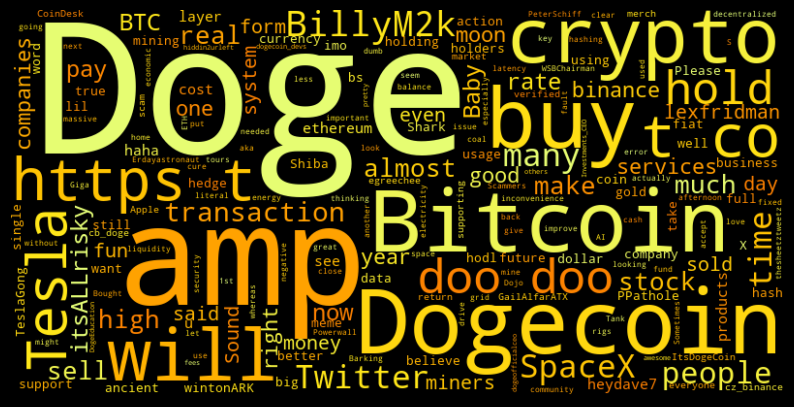

In [12]:
# Concatenate all the tweets into a single string
text = ' '.join(df_musk_doge['Text'].tolist())

# Generate the wordcloud
wordcloud = WordCloud(width=800, height=400, max_words=200, background_color='black', colormap='Wistia').generate(text)

# Configure the plot
plt.figure(figsize=(10,10), facecolor='k', dpi=100)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### 5. Statistical models

In order to analyze the relationship between Elon Musk's tweets and DOGE price and volatility we need to make a series of steps before implementing a statistic model. After doing some format transformation, we merge `df_musk_doge` and `df_doge` to put all the data in one dataframe. 

Then, we create a column named `Text_Polarity` to indicate the presence of an Elon tweet relative to DOGE and two columns `close_pct_change` and `vol_pct_change`to contain the variation of price and volatility in percentage.

In [13]:
# Rename column as timestamp
df_musk_doge = df_musk_doge.rename(columns={'CreatedAt': 'timestamp'})

# Assuming 'timestamp' is already in datetime format
df_musk_doge['timestamp'] = df_musk_doge['timestamp'].dt.strftime('%Y-%m-%d %H:00:00')

# Convert timestamp column to datetime format
df_musk_doge['timestamp'] = pd.to_datetime(df_musk_doge['timestamp'])

# Group the data frame by timestamp and concatenate the processed_text column
df_musk_doge['processed_text'] = df_musk_doge['processed_text'].fillna('')
df_musk_doge_gr = df_musk_doge.groupby('timestamp').agg({'processed_text': lambda x: ' '.join(x)})

# Merge the data frames
df_model = pd.merge(df_musk_doge_gr, df_doge, on='timestamp', how='right')

# Create a text polarity column
df_model['Text_Polarity'] = df_model['processed_text'].apply(lambda x: 0 if pd.isna(x) else 1)

# Calculate percent change in closing price
df_model['close_pct_change'] = df_model['close'].pct_change() * 100
df_model['close_pct_change'] = df_model['close_pct_change'].round(4)

# Calculate percent change in volatility
df_model['vol_pct_change'] = df_model['volatility'].pct_change() * 100
df_model['vol_pct_change'] = df_model['vol_pct_change'].round(4)

df_model.sample(5)

timestamp processed_text      open      high       low  \
9439  2022-01-29 20:00:00            NaN  0.142400  0.144200  0.142200   
721   2021-01-31 01:00:00            NaN  0.028015  0.030489  0.027982   
12026 2022-05-17 15:00:00            NaN  0.088800  0.089500  0.088300   
2374  2021-04-10 00:00:00            NaN  0.061610  0.061700  0.060944   
18305 2023-02-03 06:00:00            NaN  0.092180  0.092200  0.091660   

          close        volume  volatility  Text_Polarity  close_pct_change  \
9439   0.143100  4.436921e+07    0.540431              0            0.5622   
721    0.029414  1.096707e+09    9.134150              0            4.9986   
12026  0.089100  4.145294e+07    0.730006              0            0.3378   
2374   0.061296  5.365816e+07    1.172791              0           -0.4744   
18305  0.091730  1.812725e+07    0.959646              0           -0.4990   

       vol_pct_change  
9439          -1.9592  
721            0.4513  
12026         -1.7454  
2374           0.2232  
18305         -0.6458

### Price analysis

We can visualize the percent change of DOGE after Elon Musk tweets in a Plotly chart:


In [68]:
# Filter the data to include only Elon Musk tweets
doge_on_elon_tweets = df_model[df_model["Text_Polarity"] == 1]

# Create a trace for the percent change
trace1 = go.Bar(x=df_model['timestamp'], y=df_model['close_pct_change'], name='DOGE/USDT % chg.', marker=dict(color='#e1b303'), marker_line_width=0, opacity=0.4)
trace2 = go.Bar(x=doge_on_elon_tweets['timestamp'], y=doge_on_elon_tweets['close_pct_change'], name='DOGE/USDT % chg. after Elon tweet', marker=dict(color='#00acee'), marker_line_width=0)

# Create a list of vertical line positions
vertical_lines = df_model[df_model['processed_text'].notna()]['timestamp']

# Configure the layout
layout = go.Layout(title='DogeCoin Percent of Change After Elon Musk Tweets', xaxis=dict(title='Date'), yaxis=dict(title='DogeCoin Percent of Change'))
layout.legend=dict(
    orientation="h",
    yanchor="top",
    y=1.2,
    xanchor="right",
    x=1
)
# Combine the traces into a single plot
data = [trace1, trace2]

# Create the figure
fig = go.Figure(data=data, layout=layout)
fig.show()

As we can see in the graph above, the tweets led to important fluctuations in price, but not all the tweets produced positive impacts. In order to analyze the strong of the correlation, a first approximation is to compare the mean price change of DOGE/USDT with the mean price change after Elon Musk posts a DOGE-related tweet.

In [16]:
# Total mean
total_mean_price_change = df_model["close_pct_change"].mean()

# Compute the mean price change and volatility change after each Elon Musk tweet
mean_price_change = doge_on_elon_tweets["close_pct_change"].mean()

# Print the results
print("Mean price change: {:.2f}%".format(total_mean_price_change))
print("Mean price change after Elon Musk's tweet:: {:.2f}%".format(mean_price_change))

Mean price change: 0.03%
Mean price change after Elon Musk's tweet:: 1.71%


The mean price change before the tweet was found to be 0.03%, whereas after the tweets, the mean price change was found to be 1.71%. This suggests that Elon Musk's tweets had a significant impact on the price of the asset, causing a much larger price change than the average price change before the tweets. We may conclude that Elon Musk's tweets can be important signals for predicting future price movements of the asset, but for a deeper analysis we need to apply a stadistic model.

ANOVA is a statistical method used to analyze the differences among means and to test the hypothesis of whether these differences are statistically significant. In this case, we are using it to examine whether there is a significant relationship between the sentiment of Elon Musk's tweets (measured by Text_Polarity) and the percentage change in the price of DOGE (close_pct_change). The summary of the ANOVA model provides information about the model fit, including the R-squared value, F-statistic, and p-value, which can help us to determine the strength of the relationship between the two variables.

In [17]:
# Fit the ANOVA model
model = smf.ols('close_pct_change ~ Text_Polarity', data=df_model).fit()

# Print the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       close_pct_change   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     118.9
Date:                Thu, 20 Apr 2023   Prob (F-statistic):           1.30e-27
Time:                        15:56:31   Log-Likelihood:                -41153.
No. Observations:               20140   AIC:                         8.231e+04
Df Residuals:                   20138   BIC:                         8.233e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0188      0.013      1.426

The ANOVA test results with a dependent variable of close_pct_change and an independent variable of Text_Polarity show that the model has an R-squared value of 0.006, indicating that only 0.6% of the variance in close_pct_change is explained by Text_Polarity. The F-statistic of 118.9 suggests that the model is statistically significant, and the P-value of less than 0.05 for Text_Polarity indicates that it is a significant predictor of close_pct_change.

Overall, the model suggests that Text_Polarity may have some predictive power over close_pct_change, but the low R-squared value indicates that it is not a strong predictor. The high kurtosis value and potential for outliers suggest that the model may not be entirely reliable, and further analysis may be necessary before using it as a base for a trading strategy.

### Volatility analysis

We can visualize the percent change of DOGE volatility after Elon Musk tweets in a Plotly chart:


In [18]:
# Create a trace for the percent change
trace1 = go.Bar(x=df_model['timestamp'], y=df_model['vol_pct_change'], name='DOGE/USDT % chg.', marker=dict(color='red'), marker_line_width=0, opacity=0.4)
trace2 = go.Bar(x=doge_on_elon_tweets['timestamp'], y=doge_on_elon_tweets['vol_pct_change'], name='DOGE/USDT % chg. after Elon tweet', marker=dict(color='#00acee'), marker_line_width=0)

# Create a list of vertical line positions
vertical_lines = df_model[df_model['processed_text'].notna()]['timestamp']

# Configure the layout
layout = go.Layout(title='DogeCoin Percent of vol After Elon Musk Tweets', xaxis=dict(title='Date'), yaxis=dict(title='DogeCoin Percent of Change'))
layout.legend=dict(
    orientation="h",
    yanchor="top",
    y=1.2,
    xanchor="right",
    x=1
)

# Combine the traces into a single plot
data = [trace1, trace2]

# Create the figure
fig = go.Figure(data=data, layout=layout)
fig.show()

The chart reveals the presence of several volatility spikes that, in some cases, coincide with tweets by Elon Musk posted at the same time. Again, a first approximation is to compare the mean volatility change of DOGE/USDT with the mean volatility change after Elon Musk posts a DOGE-related tweet.

In [69]:
# Total metrics
total_mean_volatility_change = df_model["vol_pct_change"].mean()

# Compute the mean price change and volatility change after each Elon Musk tweet
mean_volatility_change = doge_on_elon_tweets["vol_pct_change"].mean()

# Print the results
print("Mean volatility change: {:.4f}%".format(total_mean_volatility_change ))
print("Mean volatility change after Elon Musk's tweet: {:.4f}%".format(mean_volatility_change))

Mean volatility change: 0.4397%
Mean volatility change after Elon Musk's tweet: 10.4296%


This indicates that there was a significant change in volatility after Elon Musk tweeted, much more notorious than the change produced in the price. The mean volatility change was 0.4397%, while the mean volatility change after Elon Musk tweeted was 10.4296%. This suggests that Elon Musk's tweets had a considerable impact on the volatility of the market, but for a deeper analysis we need to apply a stadistic model.

In [20]:
# Fit the ANOVA model
model = smf.ols('vol_pct_change ~ Text_Polarity', data=df_model).fit()

# Print the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         vol_pct_change   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     97.43
Date:                Thu, 20 Apr 2023   Prob (F-statistic):           6.29e-23
Time:                        15:57:04   Log-Likelihood:                -78982.
No. Observations:               20116   AIC:                         1.580e+05
Df Residuals:                   20114   BIC:                         1.580e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.3667      0.087      4.222

The model resulted in an R-squared value of 0.005, which indicates that only 0.5% of the variability in the vol_pct_change can be explained by Text_Polarity. On the other hand, the coefficient of Text_Polarity is 10.0714, which indicates that a one-unit increase in Text_Polarity is associated with increases in vol_pct_change. Also, the F-statistic of 98.14 indicates that the model is significant, meaning that there is strong evidence to suggest that there is a relationship between Text_Polarity and vol_pct_change. In conclusion, the analysis shows that Elon Musk tweets related to DOGE have a statistically significant relationship with DOGE volatility. However, the R-squared value suggests that other factors might have a more significant impact on DOGE volatility.

To go one step further, we can analyze the ANOVA table.The ANOVA table shows the degrees of freedom, the sum of squares, the mean square, the F-statistic, and the associated p-value for each of the variables in the model. The ANOVA table can be used to test the significance of the variables in the model and to compare the fit of different models.

In [22]:
# Perform the ANOVA test
anova_table = anova_lm(model)

# Print the ANOVA table
print(anova_table)

                    df        sum_sq       mean_sq          F        PR(>F)
Text_Polarity      1.0  1.467699e+04  14676.994239  97.431056  6.287511e-23
Residual       20114.0  3.029969e+06    150.639795        NaN           NaN


As per the ANOVA table output, the p-value for the variable "Text_Polarity" is less than the significance level of 0.05, which indicates that there is a significant relationship between "Text_Polarity" and "vol_pct_change" in the model. It means that Elon Musk tweets related to DOGE have a statistically significant impact on the volatility of the cryptocurrency.

Based on this analysis, it could be a good idea to use Elon Musk tweets related to DOGE as a signal of a potential increment in the volatility. Traders could use this signal to buy options or enter into volatility trades to profit from the expected increase in volatility. However, it is important to note that other factors should also be considered to avoid risks and maximize profitability.

### 6. Possible trading strategies and final thoughts

As we could see in the statistical analysis of the correlation with prices and volatility, a trading strategy that seeks to predict jumps in volatility based on Elon Musk's tweets referring to Dogecoin would have more strength than a strategy that seeks to benefit from price changes.

We can attribute these results to the fact that the applied Natural Language Processing procedures filtered the tweets that were related to the topic, without distinguishing between those that had a positive or negative charge. Another possible approach to obtain a model with a higher correlation with positive price changes could include a sentiment analysis.

As for the possible strategies that take advantage of increases in volatility, they would involve the use of derivatives on DOGE/USDT. Exchanges such as Binance, ByBit and DeriBit offer the possibility of trading options on crypto assets.

Options trading strategies such as the straddles, strangles, straps, and strips can be powerful tools for traders looking to take advantage of potential volatility caused by Elon Musk's tweets related to DOGE. These strategies can help traders limit their exposition to price movement while profiting from the increased volatility caused by Musk's tweets:

**Straddle**: A straddle involves buying a call and a put option at the same strike price and expiration date. This strategy profits when the underlying asset's price moves significantly in either direction.

**Strangle**: A strangle is similar to a straddle, but instead of buying options at the same strike price, the call and put options have different strike prices. This strategy profits when the underlying asset's price moves significantly but is more flexible than the straddle as the options' strike prices can be adjusted to suit the trader's expectations.

**Strap**: A strap is a bullish options trading strategy that involves buying two call options and one put option at the same strike price and expiration date. This strategy is profitable if the underlying asset's price increases significantly.

**Strip**: A strip is a bearish options trading strategy that involves buying two put options and one call option at the same strike price and expiration date. This strategy is profitable if the underlying asset's price decreases significantly.



In [66]:
# Define the option contract details
strike_price = 0.30
call_price = 0.02
put_price = 0.01

# Define the underlying asset price range
underlying_price = np.arange(0.20, 0.40, 0.01)

# Define the payoff and profit functions for each strategy
def straddle_payoff(underlying_price):
    return (np.maximum(underlying_price - strike_price, 0) - call_price + np.maximum(strike_price - underlying_price, 0) - put_price) * 100

def strangle_payoff(underlying_price):
    return (np.where(underlying_price < strike_price - 0.02, 0, underlying_price - strike_price + 0.02)
            - call_price + np.where(underlying_price > strike_price + 0.02, 0, strike_price - underlying_price + 0.02)
            - put_price) * 100

def strap_payoff(underlying_price):
    return (np.maximum(underlying_price - strike_price, 0) - 2*call_price) * 100

def strip_payoff(underlying_price):
    return (np.maximum(strike_price - underlying_price, 0) - 2*put_price) * 100

# Create the subplots
fig = make_subplots(rows=2, cols=2,
                    subplot_titles=('Straddle', 'Strangle', 'Strap', 'Strip'),    
                    vertical_spacing=0.3,
                    horizontal_spacing=0.1)

# Add the payoff and profit lines for each strategy
fig.add_trace(go.Scatter(x=underlying_price, y=straddle_payoff(underlying_price), name='Straddle Payoff'), row=1, col=1)
fig.add_trace(go.Scatter(x=underlying_price, y=strangle_payoff(underlying_price), name='Strangle Payoff'), row=1, col=2)
fig.add_trace(go.Scatter(x=underlying_price, y=strap_payoff(underlying_price), name='Strap Payoff'), row=2, col=1)
fig.add_trace(go.Scatter(x=underlying_price, y=strip_payoff(underlying_price), name='Strip Payoff'), row=2, col=2)

# Define the strike prices
strike_price_strangle = 0.32
strike_price_strap = 0.28
strike_price_strip_call = 0.32
strike_price_strip_put = 0.28

# Calculate the payoffs and profits for the strangle option strategy
payoff_strangle = ((np.maximum(underlying_price - strike_price_strangle, 0) - call_price) +
(np.maximum(strike_price_strangle - underlying_price, 0) - put_price)) * 100

# Calculate the payoffs and profits for the strap option strategy
payoff_strap = (np.minimum(strike_price_strap - underlying_price, 0) - call_price +
np.minimum(underlying_price - strike_price_strap, 0) - put_price) * 100

# Calculate the payoffs and profits for the strip option strategy
payoff_strip_call = (np.minimum(strike_price_strip_call - underlying_price, 0) - call_price) * -100
payoff_strip_put = (np.minimum(underlying_price - strike_price_strip_put, 0) - put_price) * -100
payoff_strip = payoff_strip_call + payoff_strip_put

# Add the subplots
fig.add_trace(go.Scatter(x=underlying_price, y=payoff_strap, name='Strap', visible=False))
fig.add_trace(go.Scatter(x=underlying_price, y=payoff_strip, name='Strip', visible=False))

# Set the axis labels and titles
fig.update_xaxes(title_text='Underlying Asset Price', row=1, col=1)
fig.update_yaxes(title_text='Returns', row=1, col=1)
fig.update_xaxes(title_text='Underlying Asset Price', row=1, col=2)
fig.update_yaxes(title_text='Returns', row=1, col=2)
fig.update_xaxes(title_text='Underlying Asset Price', row=2, col=1)
fig.update_yaxes(title_text='Returns', row=2, col=1)
fig.update_xaxes(title_text='Underlying Asset Price', row=2, col=2)
fig.update_yaxes(title_text='Returns', row=2, col=2)
fig.update_layout(title='Example Option Strategies on DOGE/USDT')
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="top",
    y=1.2,
    xanchor="right",
    x=1
))

# Show the plot
fig.show()